In [5]:
import torch
from torch_geometric.data import Data
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx
from tqdm.auto import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

import os.path as osp

import torch
from torch_geometric.data import Dataset, download_url, InMemoryDataset
from torch_geometric.io import fs

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.optim as optim

<h1>Explore the LUCAS0 dataset</h1>

Here is the structure of the LUCAS0 dataset:

<img src="images/lucas0_structure.png" alt="Structure of the LUCAS0 dataset." width=600 height=400>

Here are how the features are connected:
* [Anxiety, Smoking] -> [2, 0]
* [Peer Pressure, Smoking] -> [3, 0]
* [Smoking, Yellow Fingers] -> [0, 1]
* [Smoking, Lung Cancer] -> [0, 11]
* [Genetics, Lung Cancer] -> [4, 11]
* [Genetics, Attention Disorder] -> [4, 5]
* [Attention Disorder, Car Accident] -> [5, 7]
* [Lung Cancer, Coughing] -> [11, 10]
* [Lung Cancer, Fatigue] -> [11, 8]
* [Allergy, Coughing] -> [9, 10]
* [Coughing, Fatigue] -> [10, 8]
* [Fatigue, Car Accident] -> [8, 7]

The from nodes are the first element, given by
* [2, 3, 0, 0, 4, 4, 5, 11, 11, 9, 10, 8],

and the to nodes are the second element, given by
* [0, 0, 1, 11, 11, 5, 7, 10, 8, 10, 8, 7].

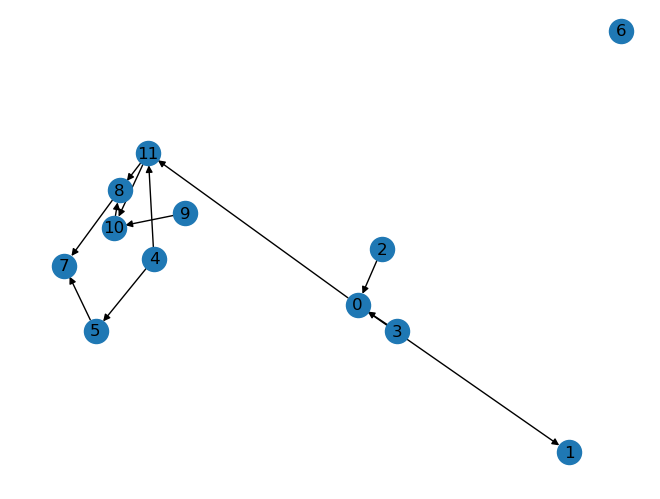

In [6]:
class LUCAS0Dataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(LUCAS0Dataset, self).__init__(root, transform, pre_transform)
        self.data = fs.torch_load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['lucas0_train.csv']

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        # Download to `self.raw_dir`.
        download_url('https://www.causality.inf.ethz.ch/data/lucas0_train.csv', self.raw_dir)

    def process(self):
        print(self.processed_paths)
        # Load in the data
        self.data = pd.read_csv(self.raw_paths[0])
        
        # Get the node features
        self._get_node_features()
        
        # Get the edge index
        self._get_edge_index()
    
        # Get the labels
        self._get_labels()
        
        # Save the data
        data = Data(x=self.X, edge_index=self.edge_index, y=self.y)
        
        # Save the data
        torch.save(data, osp.join(self.processed_dir, 'data.pt'))
        
        
    def _get_node_features(self):
        self.X = torch.tensor(self.data.values, dtype=torch.float).t()
        
    
    def _get_edge_index(self):
        from_list = [2, 3, 0, 0 , 4 , 4, 5, 11, 11, 9 , 10, 8]
        to_list   = [0, 0, 1, 11, 11, 5, 7, 10, 8 , 10, 8 , 7]
        self.edges = [(i, j) for i, j in zip(from_list, to_list)]  # Connect all nodes
        self.edge_index = torch.tensor(self.edges, dtype=torch.long).t().contiguous()
    
    
    def _get_labels(self):
        self.y = torch.tensor(self.data.Lung_cancer.values, dtype=torch.float)        


    def len(self):
        return len(self.processed_file_names)

dataset = LUCAS0Dataset(root='data/')[0]

# Visualize the graph
G = to_networkx(dataset)
nx.draw(G, with_labels=True)
plt.show()

In [7]:
# Load the dataset
df = pd.read_csv('data/raw/lucas0_train.csv')
df

,Smoking,Yellow_Fingers,Anxiety,Peer_Pressure,Genetics,Attention_Disorder,Born_an_Even_Day,Car_Accident,Fatigue,Allergy,Coughing,Lung_cancer
0,0,0,1,0,0,1,0,1,0,1,0,0
1,0,1,0,0,0,0,1,0,1,0,1,1
2,1,1,1,0,1,1,1,1,1,1,1,1
3,0,0,0,1,0,0,1,0,0,0,0,0
4,1,1,1,0,0,1,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,1,0,0,0,0,1,1,0,1,1
1996,1,1,1,0,0,0,0,0,1,0,1,1
1997,1,1,0,1,0,0,1,0,1,0,0,1
1998,1,1,1,0,1,1,0,1,1,0,1,1


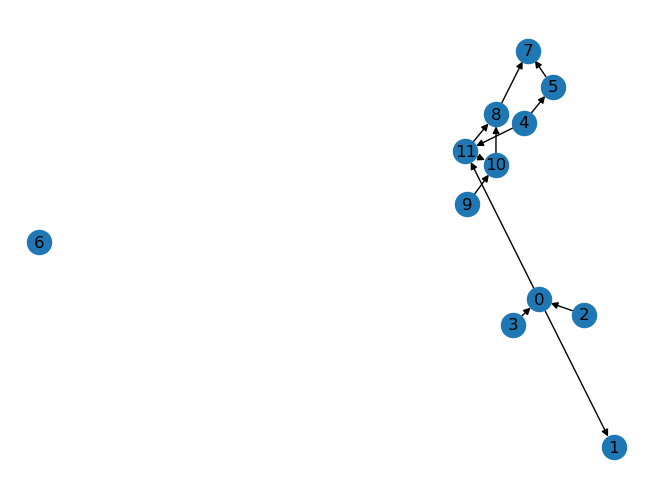

In [30]:
# Your tabular data
tabular_data = df.values

from_list = [2, 3, 0, 0, 4, 4, 5, 11, 11, 9, 10, 8]
to_list   = [0, 0, 1, 11, 11, 5, 7, 10, 8, 10, 8, 7]

# Create graph data
edges = [(i, j) for i, j in zip(from_list, to_list)]  # Connect all nodes
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Node features
x = torch.tensor(tabular_data, dtype=torch.float).t()
y = torch.tensor(df.Lung_cancer.values, dtype=torch.float)

# Assuming there are no node labels or edge features in this example
data = Data(x=x, edge_index=edge_index, y=y)

# Plot the data using networkx
G = to_networkx(data)
nx.draw(G, with_labels=True)

In [54]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, 64)
        self.conv2 = GCNConv(64, 128)
        self.conv3 = GCNConv(128, 256)
        self.conv4 = GCNConv(256, 128)
        self.conv5 = GCNConv(128, output_dim)

    def forward(self, x, edge_index):
        # Apply first graph convolution
        x = x.t()
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)    
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)    

        # Apply second graph convolution
        x = self.conv5(x, edge_index)
        return x


# Define model dimensions
print(tabular_data.shape)
input_dim = tabular_data.shape[1]  # Number of input features
hidden_dim = 64
output_dim = 1  # Assuming binary classification (e.g., Lung Cancer prediction)
model = GCN(input_dim, output_dim)

# Print the number of parameters
print(f'The model has {sum(p.numel() for p in model.parameters())} parameters')





# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

def train_model(model, data, epochs=20):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        # print all the attributes of data
        loss = criterion(out.squeeze(), data.y)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

# Train the model
train_model(model, data, epochs=200)


(2000, 12)
The model has 75201 parameters
Epoch 0, Loss: 0.6651010513305664
Epoch 10, Loss: 0.4213516414165497
Epoch 20, Loss: 0.224370539188385
Epoch 30, Loss: 0.07275210320949554
Epoch 40, Loss: 0.009073570370674133
Epoch 50, Loss: 0.009910253807902336
Epoch 60, Loss: 0.010773580521345139
Epoch 70, Loss: 0.011934938840568066
Epoch 80, Loss: 0.007345416117459536
Epoch 90, Loss: 0.008250023238360882
Epoch 100, Loss: 0.006640778388828039
Epoch 110, Loss: 0.007289445493370295
Epoch 120, Loss: 0.004676437471061945
Epoch 130, Loss: 0.0065905991941690445
Epoch 140, Loss: 0.005776985082775354
Epoch 150, Loss: 0.005792221054434776
Epoch 160, Loss: 0.006599957123398781
Epoch 170, Loss: 0.00571642117574811
Epoch 180, Loss: 0.004521139897406101
Epoch 190, Loss: 0.008831849321722984


In [55]:
def predict(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        predicted_labels = torch.sigmoid(out)  # Sigmoid activation for binary classification
        return predicted_labels

# Make predictions
predictions = predict(model, data)
print(predictions.shape)
# Evaluate the model accuracy
print(((predictions > 0.5) == data.y).shape)
print(data.y.shape[0])
accuracy = ((predictions > 0.5) == data.y).sum().item() / data.y.shape[0]**2
print(f'Accuracy: {accuracy}')
# Implement evaluation based on your specific task and dataset


torch.Size([2000, 1])
torch.Size([2000, 2000])
2000
Accuracy: 0.598346
